In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA
!pip install xgboost
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1
import warnings
warnings.simplefilter('ignore', FutureWarning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.patches as patches
from sklearn.metrics import jaccard_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
from imblearn.combine import SMOTEENN

In [3]:
train_df = pd.read_csv('/kaggle/input/data-split/train_split/10/train_october.csv')
test_df = pd.read_csv('/kaggle/input/data-split/train_split/10/test_october.csv')

In [4]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row', 'col'])
y_train = (train_df['AWS'] > 0).astype(int)

X_test = test_df.drop(columns=['AWS', 'datetime', 'row', 'col'])
y_test = (test_df['AWS'] > 0).astype(int)

# Chuẩn hóa dữ liệu

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Chọn đặc trưng

In [6]:
top_features =  ['EWSS', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SSHF', 'TCLW', 'TCW', 'U250', 'U850', 'V250', 'V850', 'B11B', 'B14B', 'I4B', 'IRB']

# Cân bằng dữ liệu

## SMOTE

In [7]:
# sm = SMOTE(random_state=42)
# X_sm, y_sm = sm.fit_resample(X_train, y_train)

# scaler = MinMaxScaler()
# X_train_scaled_sm = scaler.fit_transform(X_sm)
# X_test_scaled_sm = scaler.transform(X_test) 

# X_train_scaled_sm = pd.DataFrame(X_train_scaled_sm, columns=X_train.columns)
# X_test_scaled_sm = pd.DataFrame(X_test_scaled_sm, columns=X_test.columns)

## SMOTE ENN

In [8]:
# smenn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smenn.fit_resample(X_train, y_train)

# scaler = MinMaxScaler()
# X_train_scaled_smenn = scaler.fit_transform(X_resampled)
# X_test_scaled_smenn = scaler.transform(X_test) 

# X_train_scaled_smenn = pd.DataFrame(X_train_scaled_smenn, columns=X_train.columns)
# X_test_scaled_smenn = pd.DataFrame(X_test_scaled_smenn, columns=X_test.columns)


# Mô hình tốt nhất

# XGBoost

Accuracy : 0.8538272931851006
Precision: 0.649947468773104
Recall   : 0.8044598564754611
F1 Score : 0.7189961689122293

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90     68556
           1       0.65      0.80      0.72     20763

    accuracy                           0.85     89319
   macro avg       0.79      0.84      0.81     89319
weighted avg       0.87      0.85      0.86     89319



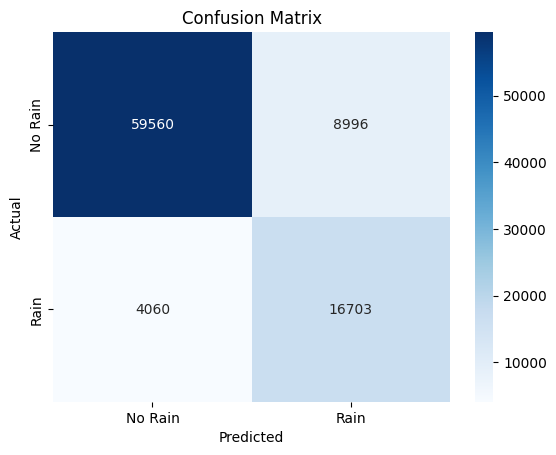

In [9]:
THRESHOLD = 0.25

xgb_model = XGBClassifier(
    n_estimators=212,
    learning_rate=0.20875431825823065,
    max_depth=3,
    min_child_weight=5,
    subsample= 0.8918808017169018,
    colsample_bytree= 0.8041383232996071,
    gamma= 3.103984882631909,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_scaled, y_train)

y_probs = xgb_model.predict_proba(X_test_scaled)[:,1]
y_pred_xgb = (y_probs >= THRESHOLD).astype(int)

acc = accuracy_score(y_test, y_pred_xgb)
prec = precision_score(y_test, y_pred_xgb)
rec = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)

print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Vẽ bản đồ mưa

In [10]:
df_map = test_df[['datetime', 'row', 'col']].copy()
df_map['y_true'] = y_test.values
df_map['y_pred_xgb'] = y_pred_xgb
df_map

,datetime,row,col,y_true,y_pred_xgb
0,2020-10-19 00:00:00,0,104,0,1
1,2020-10-19 01:00:00,0,104,0,1
2,2020-10-19 02:00:00,0,104,0,0
3,2020-10-19 03:00:00,0,104,0,0
4,2020-10-19 04:00:00,0,104,0,0
...,...,...,...,...,...
89314,2020-10-31 19:00:00,87,136,1,1
89315,2020-10-31 20:00:00,87,136,1,1
89316,2020-10-31 21:00:00,87,136,1,1
89317,2020-10-31 22:00:00,87,136,1,1


In [11]:
def evaluate(y_true, y_pred, model_name, timestamp):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    iou = jaccard_score(y_true, y_pred, zero_division=0)
    
    return {
        'Datetime': timestamp,  
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'IoU': iou
    }

In [12]:
def plot_true_vs_xgb(df_plot):
    datasets = [
        ('y_true', 'Thực tế'),
        ('y_pred_xgb', 'Dự đoán XGboost khi huấn luyện trên tháng 10')
    ]

    # Tránh SettingWithCopyWarning bằng cách tạo bản sao rõ ràng
    df_plot = df_plot.copy()

    # Chuyển datetime nếu chưa đúng kiểu
    if not df_plot.empty and not pd.api.types.is_datetime64_any_dtype(df_plot['datetime']):
        df_plot['datetime'] = pd.to_datetime(df_plot['datetime'])

    timestamp = df_plot['datetime'].iloc[0].strftime('%Y-%m-%d %H:%M:%S') if not df_plot.empty else "Không có dữ liệu"

    vmax_values = []
    images = []

    for col, _ in datasets:
        image = np.zeros((90, 250))
        for _, row in df_plot.iterrows():
            r = row['row']
            c = row['col']
            value = row[col]
            image[r, c] = value
        cropped = image[:, 50:201]
        images.append(cropped)
        vmax_values.append(np.max(cropped))
    
    max_vmax = max(vmax_values)

    fig, axs = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)
    titles = [title for _, title in datasets]

    for i, ax in enumerate(axs):
        cropped_image = images[i]
        cmap = 'Blues'
        im = ax.imshow(cropped_image, cmap=cmap, aspect='auto', vmin=0.01, vmax=max_vmax)
        ax.set_title(titles[i], fontsize=12)
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')
        ax.set_xticks(ticks=np.arange(0, cropped_image.shape[1], 10))
        ax.set_xticklabels(np.arange(50, 201, 10))

        boxes = [
            {"xy": (95 - 50, 0), "width": 21, "height": 19, "edgecolor": 'r', "label": 'Hoà Bình'},
            {"xy": (84 - 50, 10), "width": 43, "height": 35, "edgecolor": 'g', "label": 'Thanh Hoá'},
            {"xy": (71 - 50, 27), "width": 49, "height": 36, "edgecolor": 'b', "label": 'Nghệ An'},
            {"xy": (102 - 50, 62), "width": 35, "height": 18, "edgecolor": 'y', "label": 'Hà Tĩnh'}
        ]
        for box in boxes:
            rect = patches.Rectangle(**box, linewidth=2, facecolor='none')
            ax.add_patch(rect)
        
        if i == 0:
            handles = [patches.Patch(color=box["edgecolor"], label=box["label"]) for box in boxes]
            ax.legend(handles=handles, loc='upper right')

    fig.suptitle(f'Bản đồ mưa tại {timestamp}', fontsize=16, fontname='DejaVu Sans')
    fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6, label='Rain (1) / No rain (0)')

    output_filename = f"rain_map_{df_plot['datetime'].iloc[0].strftime('%Y%m%d_%H%M%S')}.png"
    plt.savefig(output_filename, dpi=300)
    print(f"✅ Đã lưu ảnh: {output_filename}")
    plt.show()


In [13]:
timestamp1 = '2020-10-19 01:00:00'
timestamp2 = '2020-10-28 20:00:00'
timestamp3 = '2020-10-29 19:00:00'
timestamp4 = '2020-10-30 08:00:00'

df_plot1 = df_map[df_map['datetime'] == timestamp1]
df_plot2 = df_map[df_map['datetime'] == timestamp2]
df_plot3 = df_map[df_map['datetime'] == timestamp3]
df_plot4 = df_map[df_map['datetime'] == timestamp4]

✅ Đã lưu ảnh: rain_map_20201019_010000.png


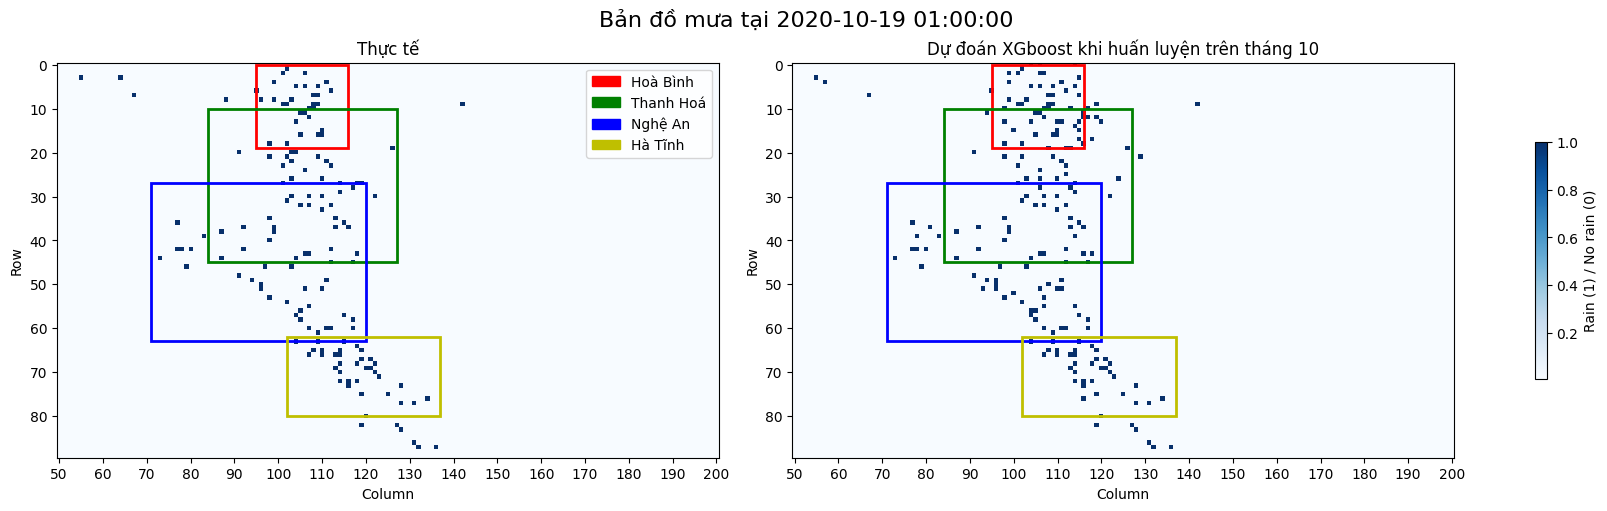

In [14]:
plot_true_vs_xgb(df_plot1)

✅ Đã lưu ảnh: rain_map_20201028_200000.png


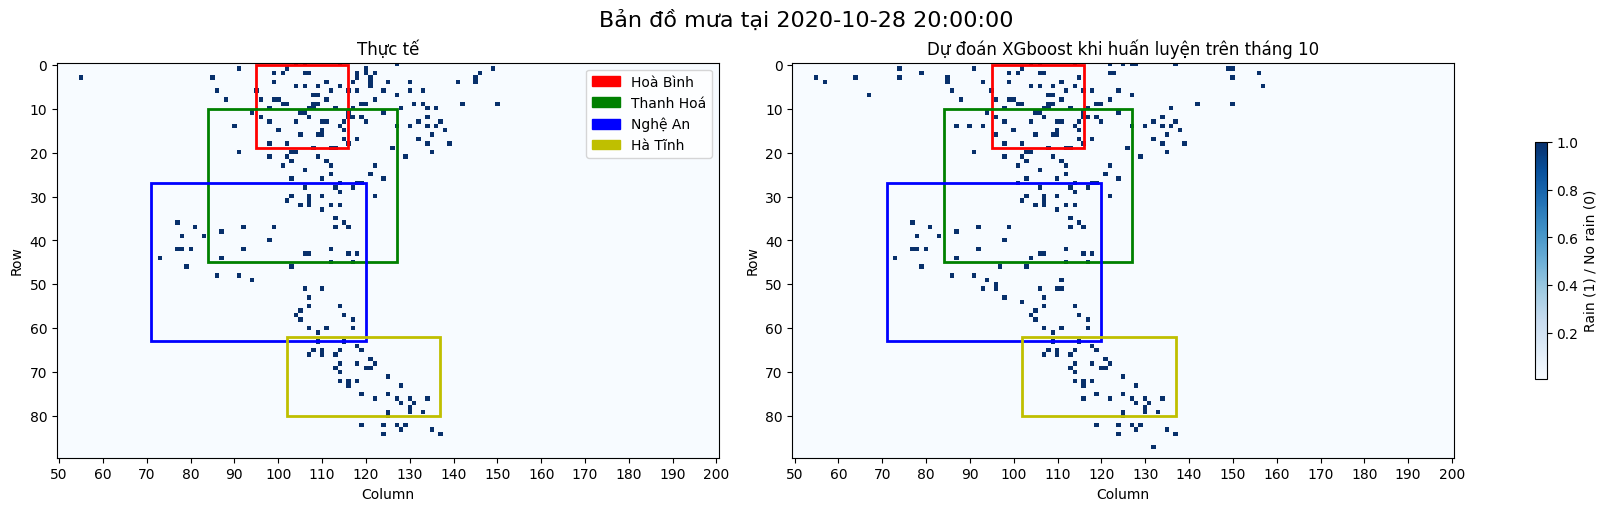

In [15]:
plot_true_vs_xgb(df_plot2)

✅ Đã lưu ảnh: rain_map_20201029_190000.png


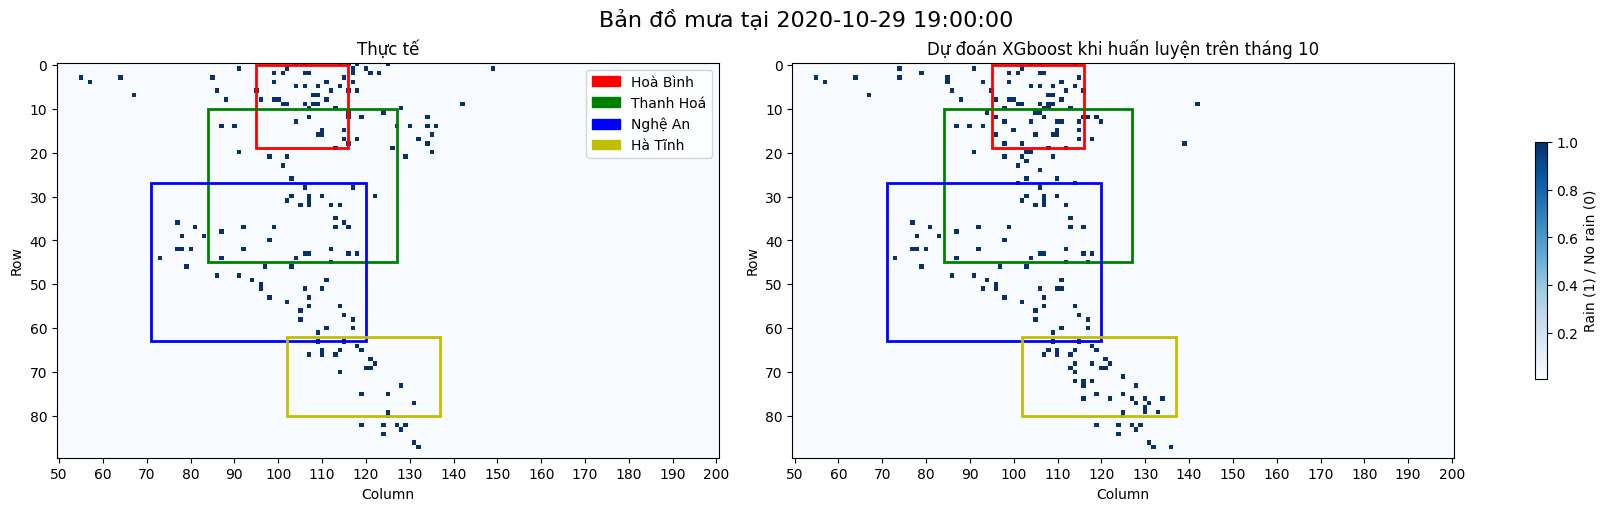

In [16]:
plot_true_vs_xgb(df_plot3)

✅ Đã lưu ảnh: rain_map_20201030_080000.png


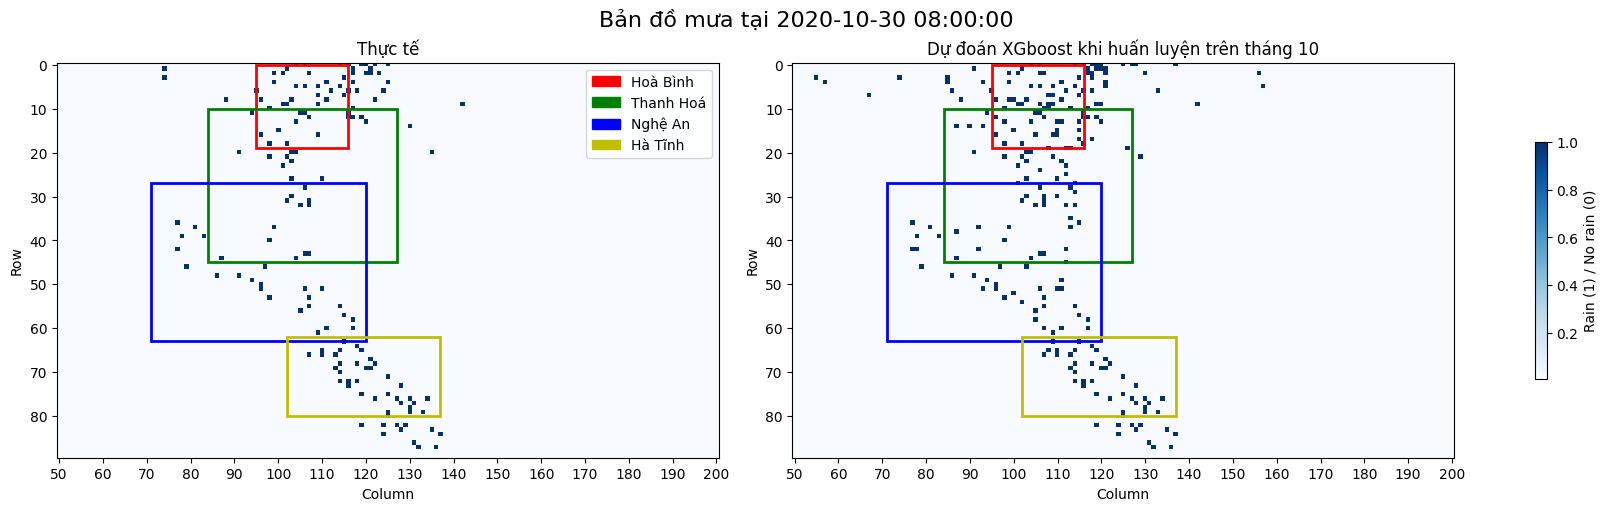

In [17]:
plot_true_vs_xgb(df_plot4)

In [18]:
results = []

results.append(evaluate(df_plot1['y_true'], df_plot1['y_pred_xgb'], 'XGBoost', timestamp1))
results.append(evaluate(df_plot2['y_true'], df_plot2['y_pred_xgb'], 'XGBoost', timestamp2))
results.append(evaluate(df_plot3['y_true'], df_plot3['y_pred_xgb'], 'XGBoost', timestamp3))
results.append(evaluate(df_plot4['y_true'], df_plot4['y_pred_xgb'], 'XGBoost', timestamp4))

df_results = pd.DataFrame(results)

df_results


,Datetime,Model,Accuracy,Precision,Recall,F1-score,IoU
0,2020-10-19 01:00:00,XGBoost,0.791667,0.738462,0.941176,0.827586,0.705882
1,2020-10-28 20:00:00,XGBoost,0.815331,0.869565,0.916667,0.892495,0.805861
2,2020-10-29 19:00:00,XGBoost,0.696864,0.715736,0.819767,0.764228,0.618421
3,2020-10-30 08:00:00,XGBoost,0.671280,0.630435,0.935484,0.753247,0.604167


In [19]:
def calculate_rain_counts_by_province(df_plot):
    regions = {
        'Hoà Bình': {'row_range': (0, 19), 'col_range': (95, 116)},
        'Thanh Hoá': {'row_range': (10, 45), 'col_range': (84, 127)},
        'Nghệ An': {'row_range': (27, 63), 'col_range': (71, 119)},
        'Hà Tĩnh': {'row_range': (62, 80), 'col_range': (102, 137)}
    }

    if df_plot.empty:
        return pd.DataFrame()

    if not pd.api.types.is_datetime64_any_dtype(df_plot['datetime']):
        df_plot.loc[:, 'datetime'] = pd.to_datetime(df_plot['datetime'])

    dt = df_plot['datetime'].iloc[0].strftime('%Y-%m-%d %H:%M:%S')

    records = []

    for region, rng in regions.items():
        row_min, row_max = rng['row_range']
        col_min, col_max = rng['col_range']

        mask = (
            (df_plot['row'] >= row_min) & (df_plot['row'] <= row_max) &
            (df_plot['col'] >= col_min) & (df_plot['col'] <= col_max)
        )

        region_data = df_plot[mask]

        true_count = (region_data['y_true'] > 0).sum()
        pred_xgb_count = (region_data['y_pred_xgb'] > 0).sum()

        records.append({
            'datetime': dt,
            'province': region,
            'true_rain_count': true_count,
            'pred_xgb_rain_count': pred_xgb_count
        })

    df_counts = pd.DataFrame(records)

    return df_counts


In [20]:
calculate_rain_counts_by_province(df_plot1)

,datetime,province,true_rain_count,pred_xgb_rain_count
0,2020-10-19 01:00:00,Hoà Bình,31,54
1,2020-10-19 01:00:00,Thanh Hoá,60,83
2,2020-10-19 01:00:00,Nghệ An,65,76
3,2020-10-19 01:00:00,Hà Tĩnh,34,35


In [21]:
calculate_rain_counts_by_province(df_plot2)

,datetime,province,true_rain_count,pred_xgb_rain_count
0,2020-10-28 20:00:00,Hoà Bình,56,58
1,2020-10-28 20:00:00,Thanh Hoá,91,96
2,2020-10-28 20:00:00,Nghệ An,63,73
3,2020-10-28 20:00:00,Hà Tĩnh,37,38


In [22]:
calculate_rain_counts_by_province(df_plot3)

,datetime,province,true_rain_count,pred_xgb_rain_count
0,2020-10-29 19:00:00,Hoà Bình,43,55
1,2020-10-29 19:00:00,Thanh Hoá,54,73
2,2020-10-29 19:00:00,Nghệ An,61,63
3,2020-10-29 19:00:00,Hà Tĩnh,20,38


In [23]:
calculate_rain_counts_by_province(df_plot4)

,datetime,province,true_rain_count,pred_xgb_rain_count
0,2020-10-30 08:00:00,Hoà Bình,38,61
1,2020-10-30 08:00:00,Thanh Hoá,38,81
2,2020-10-30 08:00:00,Nghệ An,37,63
3,2020-10-30 08:00:00,Hà Tĩnh,35,37
